<a href="https://colab.research.google.com/github/hyunku/Brain-Machine_Interface_System/blob/main/simpleESN_model_hyunku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 라이브러리 import

In [ ]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 6.9 MB/s 


In [ ]:
##필요 모듈 import
import os
import sys
import pandas as pd
import numpy as np
from scipy import signal
import mne
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt
from datetime import datetime
import time
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import math
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

MessageError: ignored

# ESN 과정 간단설명 및 ESN 정의 - spectral radius는 여기서 수정

1. ESN 모델 설정
2. train 셋 ESN 모델 통과시켜서 ESN의 가중치 학습
3. ESN 모델을 통과시킨 train 셋을 학습시킬 머신러닝 모델 학습
4. test 셋을 학습시킨 ESN모델에 통과시킴 (ESN 학습 X)
5. 통과시킨 test 데이터셋을 train셋으로 학습된 머신러닝 모델 통과시킴.
6. ESN + 머신러닝 모델을 통과시킨 결과 예측

<크게 두 단계에 걸쳐서 진행>

ESN 과 ESN 통과시킬 선형모델 생성 후 각각 학습

학습시킨 ESN, 모델 사용

In [ ]:
"""Simple Echo State Network
"""

import numpy as np
from numpy import arange, array, concatenate, ones, tanh, vstack, zeros

import scipy.linalg as la

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, check_random_state


class SimpleESN(BaseEstimator, TransformerMixin):

    # ESN 모델 설정 가능 파라미터
    def __init__(self, n_readout, n_components=100, damping=0.5,
                 weight_scaling=0.9, discard_steps=0, random_state=None):
        self.n_readout = n_readout # 출력층 뉴런 수
        self.n_components = n_components # reservoir 뉴런 수
        self.damping = damping # reservoir 내 뉴런 손실률(뉴런끼리 연결 안될 확률)
        self.weight_scaling = weight_scaling # 가중치 학습률
        self.discard_steps = discard_steps # dropout(데이터 버릴확률)
        self.random_state = check_random_state(random_state)
        self.input_weights_ = None
        self.readout_idx_ = None
        self.weights_ = None

    # ESN 모델 학습 (현재 캡슐화 상태 -> 건드리지 말라고 권장한다는 의미.)
    def _fit_transform(self, X):
        n_samples, n_features = X.shape
        X = check_array(X, ensure_2d=True)

        self.weights_ = self.random_state.rand(
            self.n_components, self.n_components)-0.5




        # 가중치 업데이트 도중 spectral_radius 추출 -> 가중치 행렬의 고유값들의 절댓값들의 최대값을 spectral radius로 정의 -> eig.weights[0] : 고유값들, eig.weights[1] : 고유벡터들
        # reservoir 뉴런 개수인 n_components 가 90이라면 90 * 90 차원의 랜덤 행렬 생성후 고유값은 90개가 나옴.
        # la.eig(self.weights_)[0]    (= 고유값) -> 고유값 계산 결과 고유값 모두 1 미만의 소수점으로 나오는 것을 확인했음 ( 2by2, 3by3, 4by4 임의 소수점으로 계산해본 결과 고유값이 모두 1미만 소수점이였음)
        # 따라서 spectral_radius 를 임의의 소수점으로 지정해도 된다는 결론이 나옴..
        # spectral_radius = np.max(np.abs(la.eig(self.weights_)[0]))   # 기본값


######## spectral_radius 값 수정가능
        # spectral_radius = np.max(np.abs(la.eig(self.weights_)[0])) # 기본값
        spectral_radius = 0.1  # 교수님께서 지정해주신 값
        # 가중치 업데이트 과정 -> weight_scaling 값으로 나눈 값으로 가중치를 업데이트함. -> weight_scaling은 가중치 학습률이다.
        self.weights_ *= self.weight_scaling / spectral_radius 
        self.input_weights_ = self.random_state.rand(self.n_components,
                                                     1+n_features)-0.5
        self.readout_idx_ = self.random_state.permutation(
            arange(1+n_features,
                   1+n_features+self.n_components))[:self.n_readout]
        self.components_ = zeros(shape=(1+n_features+self.n_components,
                                        n_samples))

        curr_ = zeros(shape=(self.n_components, 1))
        U = concatenate((ones(shape=(n_samples, 1)), X), axis=1)
        for t in range(n_samples):
            u = array(U[t, :], ndmin=2).T
            curr_ = (1-self.damping)*curr_ + self.damping*tanh(
                self.input_weights_.dot(u) + self.weights_.dot(curr_))
            self.components_[:, t] = vstack((u, curr_))[:, 0]
        return self

    # ESN 모델 통과한 인풋을 머신러닝 모델에 학습
    def fit(self, X, y=None):
        """Initialize the network

        This is more compatibility step, as no learning takes place in the
        reservoir.

        Parameters
        ----------
        X : array-like shape, (n_samples, n_features)
            The data to be transformed.

        Returns
        -------
        self : returns an instance of self.
        """
        self = self._fit_transform(X)
        return self

    # ESN 모델 학습 (가중치 학습)
    def fit_transform(self, X, y=None):
        """Generate echoes from the reservoir.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.

        Returns
        -------
        readout : array, shape (n_samples, n_readout)
            Reservoir activation generated by the readout neurons
        """
        self = self._fit_transform(X)
        return self.components_[self.readout_idx_, self.discard_steps:].T

    # 학습시킨 모델 사용(사전학습된 가중치 받아서 가중치 학습 X)
    def transform(self, X):
        """Generate echoes from the reservoir

        Parameters
        ----------
        X : array-like shape, (n_samples, n_features)
            The data to be transformed.

        Returns
        -------
        readout : array, shape (n_samples, n_readout)
            Reservoir activation generated by the readout neurons
        """
        X = check_array(X, ensure_2d=True)
        n_samples, n_features = X.shape

        # -0.x 부분이 spectral_radius 수정 부분(가중치 파라미터 수정 후 그걸로 spectral_radius 결정됨) -> fit transform 에서 수정했던 동일한 수치로 고쳐주기.
        if self.weights_ is None:
            self.weights_ = self.random_state.rand(self.n_components,
                                                   self.n_components)-0.5

        
        # 가중치 업데이트 도중 spectral_radius 추출 -> 가중치 행렬의 고유값들의 절댓값들의 최대값을 spectral radius로 정의 -> eig.weights[0] : 고유값들, eig.weights[1] : 고유벡터들
        # reservoir 뉴런 개수인 n_components 가 90이라면 90 * 90 차원의 랜덤 행렬 생성후 고유값은 90개가 나옴.
        # la.eig(self.weights_)[0]    (= 고유값) -> 고유값 계산 결과 고유값 모두 1 미만의 소수점으로 나오는 것을 확인했음 ( 2by2, 3by3, 4by4 임의 소수점으로 계산해본 결과 고유값이 모두 1미만 소수점이였음)
        # 따라서 spectral_radius 를 임의의 소수점으로 지정해도 된다는 결론이 나옴..

   
########### spectral_radius 값 수정가능      
            # spectral_radius = np.max(np.abs(la.eig(self.weights_)[0]))  # 기본값
            spectral_radius = 0.1  # 교수님께서 지정해주신 값
            self.weights_ *= self.weight_scaling / spectral_radius

        if self.input_weights_ is None:
            self.input_weights_ = self.random_state.rand(self.n_components,
                                                         1+n_features)-0.5
        if self.readout_idx_ is None:
            self.readout_idx_ = self.random_state.permutation(
                arange(1+n_features,
                       1+n_features+self.n_components))[:self.n_readout]
        self.components_ = zeros(shape=(1+n_features+self.n_components,
                                        n_samples))

        curr_ = zeros(shape=(self.n_components, 1))
        U = concatenate((ones(shape=(n_samples, 1)), X), axis=1)
        for t in range(n_samples):
            u = array(U[t, :], ndmin=2).T
            curr_ = (1-self.damping)*curr_ + self.damping*tanh(
                self.input_weights_.dot(u) + self.weights_.dot(curr_))
            self.components_[:, t] = vstack((u, curr_))[:, 0]

        return self.components_[self.readout_idx_, self.discard_steps:].T

# 2. 데이터 로드

In [ ]:
''' 연희 수집 데이터 읽기 '''

EEG_TRAIN_DIR = "/content/drive/Shareddrives/MindPong/code/rawdata/eeg+train"
DAILY_LIST_base = os.listdir(EEG_TRAIN_DIR) 
del DAILY_LIST_base[-1] # delete directory named try_psd 

DAILY_LIST = []
eeg = pd.DataFrame()
train = pd.DataFrame()

for i in DAILY_LIST_base: # make path into EEG_TRAIN_DIR / 1day ~ 16day
  DAILY_LIST.append(os.path.join(EEG_TRAIN_DIR, i))

for idx, filepath_list in enumerate(DAILY_LIST):
  files = os.listdir(filepath_list)
  for file in files:
    if "train" in file:
      imsi = pd.read_csv(os.path.join(DAILY_LIST[idx],file))
      train = pd.concat([train, imsi])
    elif "eeg" in file:
      imsi = pd.read_csv(os.path.join(DAILY_LIST[idx],file))
      eeg = pd.concat([eeg, imsi])

eeg.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [ ]:
# 수집 데이터 동적 할당을 위한 코드

# for root, directorys, filenames in os.walk(EEG_TRAIN_DIR):
#   for directory in directorys:

#     for i in range(1,len(directorys)+1,1):
#       globals()["train_{}day".format(i)] = pd.DataFrame()

#       for root_d, directorys_d, filenames_d in os.walk(DAILY_DIR):
#         for filename_d in filenames_d:
#           if "train" in filename_d:
#             imsi = pd.read_csv(os.path.join(DAILY_DIR,filename_d))
#             globals()["train_{}day".format(i)] = pd.concat([globals()["train_{}day".format(i)], imsi])
#           if "eeg" in filename_d:
#             globals()["eeg_{}day".format(i)] = pd.read_csv(os.path.join(DAILY_DIR,filename_d))

In [ ]:
''' 현구 수집 데이터 읽기 '''
# EEG_DIR = "/content/drive/MyDrive/MNE/pongdata/eeg"
# TRAIN_DIR = "/content/drive/MyDrive/MNE/pongdata/train"


# eeg = pd.DataFrame()
# train = pd.DataFrame()

# for root, _, filenames in os.walk(EEG_DIR): # root, directorys, filenames
#   for filename in filenames:
#     imsi = pd.read_csv(os.path.join(root,filename))
#     eeg = pd.concat([eeg, imsi])

# for root, _, filenames in os.walk(TRAIN_DIR):
#   for filename in filenames:
#     imsi = pd.read_csv(os.path.join(root,filename))
#     train = pd.concat([train, imsi])

# eeg.reset_index(drop=True, inplace=True)
# train.reset_index(drop=True, inplace=True)

In [ ]:
# hyunku's data - 16chan
eeg

,timestamp,ch0-time0,ch0-time1,ch0-time2,ch0-time3,ch0-time4,ch0-time5,ch0-time6,ch0-time7,ch0-time8,...,ch15-time52,ch15-time53,ch15-time54,ch15-time55,ch15-time56,ch15-time57,ch15-time58,ch15-time59,ch15-time60,ch15-time61
0,2022-06-05T20:37:29.601036,-4501.618982,-8994.721948,-8841.031354,-9027.266088,-8808.978952,-9052.724725,-8786.694263,-9070.114383,-8771.182152,...,-114649.629849,-114775.380763,-114663.711448,-114745.474129,-114682.084582,-114715.053405,-114704.413975,-114682.151637,-114719.657865,-114646.969992
1,2022-06-05T20:37:30.109032,-9029.277745,-8817.986705,-8999.214649,-8853.391868,-8964.547093,-8891.546296,-8925.699762,-8929.365448,-8879.185781,...,-114419.719806,-114607.206238,-114405.414689,-114602.691186,-114401.704300,-114594.935130,-114405.392337,-114579.601834,-114412.857820,-114552.422113
2,2022-06-05T20:37:30.611044,-9041.772371,-8755.334765,-9051.718897,-8746.461123,-9046.577996,-8746.796399,-9039.246623,-8762.353213,-9021.432283,...,-114300.048566,-114321.148613,-114267.794999,-114338.135938,-114238.290696,-114355.860872,-114214.262571,-114369.584843,-114194.749498,-114375.686869
3,2022-06-05T20:37:31.122046,-8859.873874,-8914.322724,-8819.998362,-8952.454800,-8785.129641,-8983.344911,-8758.464010,-9008.870603,-8737.542777,...,-114021.948161,-114176.354012,-114034.375731,-114148.637849,-114045.462197,-114114.774956,-114070.697316,-114090.299796,-114087.975214,-114052.033609
4,2022-06-05T20:37:31.625031,-9005.920172,-8753.434867,-8980.036852,-8782.290969,-8944.676393,-8815.952696,-8905.672599,-8854.285938,-8864.299520,...,-113822.525897,-113999.752879,-113806.075013,-113997.696519,-113792.999243,-113993.114411,-113789.065336,-113979.412792,-113793.379223,-113959.922070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87079,2022-06-22T03:31:48.182148,-7393.890011,-7401.310790,-7403.501261,-7390.045511,-7414.386560,-7379.227266,-7426.232985,-7369.213685,-7429.831616,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
87080,2022-06-22T03:31:48.696541,-7353.656871,-7434.748999,-7358.954234,-7427.752903,-7365.592702,-7421.092084,-7377.841458,-7412.017275,-7388.525592,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
87081,2022-06-22T03:31:49.209187,-7424.400142,-7360.921188,-7430.301002,-7350.997013,-7433.832578,-7346.750182,-7435.486607,-7346.906644,-7435.777180,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
87082,2022-06-22T03:31:49.720020,-7416.129996,-7377.863810,-7402.562487,-7388.637351,-7389.263199,-7397.846269,-7375.718042,-7408.284534,-7366.553827,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# yeonhee's data - 6chan
eeg

,timestamp,ch0-time0,ch0-time1,ch0-time2,ch0-time3,ch0-time4,ch0-time5,ch0-time6,ch0-time7,ch0-time8,...,ch5-time52,ch5-time53,ch5-time54,ch5-time55,ch5-time56,ch5-time57,ch5-time58,ch5-time59,ch5-time60,ch5-time61
0,2022-07-15T03:53:29.768569,-7996.761262,-8041.822379,-8000.605762,-8049.466675,-8006.685437,-8042.917614,-8011.647524,-8047.656184,-8021.504643,...,-20324.418880,-20315.120560,-20324.687100,-20316.595770,-20325.089430,-20316.774580,-20325.245900,-20320.999060,-20317.154560,-20307.878590
1,2022-07-15T03:53:30.282334,-8188.271009,-8139.968889,-8189.813279,-8127.563671,-8170.099040,-8104.139042,-8144.998031,-8087.241124,-8126.110807,...,-20188.274410,-20206.468730,-20179.534870,-20193.258850,-20197.125700,-20193.817640,-20195.896350,-20201.864270,-20194.331730,-20205.127620
2,2022-07-15T03:53:30.791950,-8080.356786,-8046.695059,-8068.018623,-8046.672707,-8064.487048,-8072.824248,-8064.040013,-8066.342243,-8053.691155,...,-20190.464880,-20194.778760,-20197.975060,-20205.440550,-20203.831220,-20191.515410,-20197.080990,-20203.317130,-20203.384190,-20209.888540
3,2022-07-15T03:53:31.300056,-8107.692970,-8045.085734,-8100.115728,-8057.602710,-8086.503516,-8017.324867,-8104.899002,-8043.901091,-8097.791147,...,-20205.976990,-20224.037200,-20231.167400,-20228.708710,-20191.738930,-20186.530970,-20180.138370,-20187.581500,-20219.991530,-20192.923570
4,2022-07-15T03:53:31.809480,-8249.134809,-8195.915305,-8221.217480,-8183.554790,-8221.217480,-8182.414851,-8187.823974,-8193.568372,-8178.860924,...,-20256.156650,-20257.073080,-20244.734910,-20245.785440,-20255.508450,-20261.454020,-20243.103240,-20250.389900,-20229.982760,-20261.006980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60718,2022-08-04T03:18:45.448528,3861.889703,3880.039320,3870.115145,3882.229791,3869.578704,3880.888686,3865.980073,3858.425183,3876.172468,...,6381.490097,6374.270484,6387.055682,6386.899219,6391.950714,6357.573731,6385.580466,6391.771900,6396.532821,6384.284065
60719,2022-08-04T03:18:45.958913,3833.860616,3840.230863,3834.240596,3840.007346,3833.190064,3818.035581,3863.431974,3770.091089,3798.097825,...,6486.230372,6490.477203,6522.440198,6488.845526,6496.154546,6490.566610,6502.167166,6495.372235,6489.985465,6502.815366
60720,2022-08-04T03:18:46.469413,3839.895587,3817.789712,3829.256157,3813.788749,3838.018040,3843.069535,3850.557369,3860.235674,3858.559294,...,6560.594626,6557.711251,6543.160265,6538.309936,6583.661626,6541.215663,6595.955085,6587.975513,6609.634353,6609.276725
60721,2022-08-04T03:18:46.979412,4372.425899,4390.687274,4396.386969,4426.606527,4428.908757,4428.931109,4438.765876,4470.930036,4479.602513,...,7044.688707,7057.205684,7075.355300,7063.508876,7078.596303,7091.403853,7077.545771,7109.821690,7108.257068,7119.768217


# 3. 전처리 + 모델링

In [ ]:
''' define parameters '''

# n_channels = 16 # hyunku
n_channels = 6 # yeonhee
s_freq = 128  # in Hertz
# ch_names = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'F3', 'F4', 'P3', 'P4'] # hyunku
ch_names = ['F7', 'F3', 'Fp1', 'Fp2', 'F4', 'F8'] # yeonhee
ch_types = ['eeg'] * n_channels
all_ch_names = ch_names + ['Task','STM']
all_ch_types = ch_types + ['misc','misc']
p_detrend = 1 # 0: OFF, 1: On
p_normalization = 1 # 0: do not, 1: [0, 1] scaling, 2: standardization (x-mean)/var
p_n_filenames = 7
p_ica_flag = 1
p_ts_psd_flag = 0
l_freqs = 1
h_freqs = 60

In [ ]:
''' Function about extract filtered data from data measured by 0.5sec and extract bandpass data from data measuerd by 3sec'''

def filtering_bandpass_update(data):

##### make filtered data by 0.5sec

  info = mne.create_info(ch_names=ch_names, sfreq=s_freq, ch_types='eeg') # make info
  st_idx = 1
  time = 62
  ch_li = []  

  # gather and average from buffer
  for chan in range(n_channels):
    ch_li.append(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].sum(axis=1) / len(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].T)) # 1 ~ 62*1 + 1, 62*1 + 1 ~ 62*2 + 1

  ch_df = pd.DataFrame(ch_li).T
  t = pd.DataFrame(data.iloc[:,0])

  # dataframe -> mne rawarray
  raw = mne.io.RawArray(ch_df.T, info, verbose=False)    # make mne object

  # filtering (by Hertz)
  raw_filtered = raw.filter(l_freq=60,h_freq=.5,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 0.5 ~ 60

  # make column names
  ch_names_arr = np.char.array(['F7', 'F3', 'Fp1', 'Fp2', 'F4', 'F8']) # yeonhee
  raw_filtered.columns = ch_names_arr

  # add time column
  df = pd.concat([t,raw_filtered], axis=1)
  origin_df = df.iloc[5:,:]
  origin_df.reset_index(drop=True, inplace=True)

  
##### make bandpass by 3sec

  # initialize info
  info = mne.create_info(ch_names=ch_names, sfreq=s_freq, ch_types='eeg') # make info
  st_idx = 1
  time = 62
  ch_li = []

  # gather and average from buffer
  for chan in range(n_channels):
    ch_li.append(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].sum(axis=1) / len(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].T)) # 1 ~ 62*1 + 1, 62*1 + 1 ~ 62*2 + 1

  ch_df = pd.DataFrame(ch_li).T

  # time rolling to gather 3sec data
  ch_df = ch_df.rolling(window=6).mean().iloc[5:,:]
  ch_df.reset_index(drop=True, inplace=True)

  # dataframe -> mne rawarray
  raw = mne.io.RawArray(ch_df.T, info, verbose=False)

  # get bandpass (by Hertz)
  delta_band = raw.filter(l_freq=4,h_freq=.5,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 0.5 ~ 4
  theta_band = raw.filter(l_freq=8,h_freq=4,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 4 ~ 8
  alpha_band = raw.filter(l_freq=12,h_freq=8,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 8 ~12
  beta_band = raw.filter(l_freq=30,h_freq=12,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 12 ~ 30
  gamma_band = raw.filter(l_freq=45,h_freq=30,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 30 ~ 45

  # make column names
  ch_names_arr = np.char.array(['F7', 'F3', 'Fp1', 'Fp2', 'F4', 'F8']) # yeonhee
  band_labels_arr = np.char.array(["-Delta", "-Theta", "-Alpha", "-Beta", "-Gamma"])
  ch_band_labels = ch_names_arr[np.newaxis, :] + band_labels_arr[:, np.newaxis]
  new_cols = ch_band_labels.flatten()

  # gather each bandpass data
  banded = pd.concat([delta_band, theta_band, alpha_band, beta_band, gamma_band], axis=1)
  banded.columns = new_cols

###### gather 0.5sec origin data and 3sec bandpass data

  filtered = pd.concat([origin_df, banded], axis=1)

  return filtered

In [ ]:
''' Function about extract filtered data and bandpass data from raw data measuerd by 0.5 sec'''

def filtering_bandpass(data): # required input data shpae : DataFrame
  info = mne.create_info(ch_names=ch_names, sfreq=s_freq, ch_types='eeg') # make info
  st_idx = 1
  time = 62
  ch_li = []
  
  # gather and average from buffer
  for chan in range(n_channels):
    ch_li.append(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].sum(axis=1) / len(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].T)) # 1 ~ 62*1 + 1, 62*1 + 1 ~ 62*2 + 1
  
  ch_df = pd.DataFrame(ch_li).T
  t = pd.DataFrame(data.iloc[:,0])
  df = pd.concat([t,ch_df], axis=1)
  
  # dataframe -> mne rawarray
  raw = mne.io.RawArray(ch_df.T, info, verbose=False)    # make mne object

  # filtering and bandpass (by Hertz)
  raw_filtered = raw.filter(l_freq=60,h_freq=.5,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 0.5 ~ 60
  delta_band = raw.filter(l_freq=4,h_freq=.5,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 0.5 ~ 4
  theta_band = raw.filter(l_freq=8,h_freq=4,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 4 ~ 8
  alpha_band = raw.filter(l_freq=12,h_freq=8,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 8 ~12
  beta_band = raw.filter(l_freq=30,h_freq=12,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 12 ~ 30
  gamma_band = raw.filter(l_freq=45,h_freq=30,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 30 ~ 45

  # make column names
  # ch_names_arr = np.char.array(['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'F3', 'F4', 'P3', 'P4']) # hyunku
  ch_names_arr = np.char.array(['F7', 'F3', 'Fp1', 'Fp2', 'F4', 'F8']) # yeonhee
  band_labels_arr = np.char.array(["-origin", "-Delta", "-Theta", "-Alpha", "-Beta", "-Gamma"])
  ch_band_labels = ch_names_arr[np.newaxis, :] + band_labels_arr[:, np.newaxis]
  new_cols = ch_band_labels.flatten()
  
  raw_filtered = pd.concat([raw_filtered, delta_band, theta_band, alpha_band, beta_band, gamma_band], axis=1)
  
  raw_filtered.columns = new_cols
  raw_filtered = pd.concat([t,raw_filtered], axis=1)

  return raw_filtered

In [ ]:
# eeg = filtering_bandpass_update(eeg)
# eeg

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 60 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 60.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 4 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 4.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-st

,timestamp,F7,F3,Fp1,Fp2,F4,F8,F7-Delta,F3-Delta,Fp1-Delta,...,Fp1-Beta,Fp2-Beta,F4-Beta,F8-Beta,F7-Gamma,F3-Gamma,Fp1-Gamma,Fp2-Gamma,F4-Gamma,F8-Gamma
0,2022-07-15T03:53:32.319493,-8.029548e+09,-2.858987e+10,-2.471825e+10,-2.442206e+10,-2.544164e+10,-2.032459e+10,-8.122937e+09,-2.865821e+10,-2.469355e+10,...,-2.469358e+10,-2.440380e+10,-2.540513e+10,-2.025565e+10,-8.122963e+09,-2.865827e+10,-2.469358e+10,-2.440380e+10,-2.540513e+10,-2.025565e+10
1,2022-07-15T03:53:32.831014,-8.024133e+09,-2.858437e+10,-2.471480e+10,-2.441467e+10,-2.543179e+10,-2.031559e+10,-8.142020e+09,-2.867684e+10,-2.469740e+10,...,-2.470274e+10,-2.440883e+10,-2.541049e+10,-2.026313e+10,-8.125506e+09,-2.866274e+10,-2.470073e+10,-2.440654e+10,-2.540792e+10,-2.025976e+10
2,2022-07-15T03:53:33.338997,-8.028384e+09,-2.859305e+10,-2.472701e+10,-2.442501e+10,-2.544387e+10,-2.033058e+10,-8.151681e+09,-2.869350e+10,-2.470121e+10,...,-2.470033e+10,-2.440183e+10,-2.540305e+10,-2.025601e+10,-8.122245e+09,-2.866111e+10,-2.470184e+10,-2.440348e+10,-2.540489e+10,-2.025852e+10
3,2022-07-15T03:53:33.852689,-8.022437e+09,-2.858635e+10,-2.472192e+10,-2.441584e+10,-2.543160e+10,-2.031878e+10,-8.162580e+09,-2.872805e+10,-2.472748e+10,...,-2.471270e+10,-2.440946e+10,-2.541091e+10,-2.026550e+10,-8.126683e+09,-2.866922e+10,-2.471372e+10,-2.441060e+10,-2.541218e+10,-2.026714e+10
4,2022-07-15T03:53:34.356027,-8.026798e+09,-2.859572e+10,-2.473532e+10,-2.442747e+10,-2.544556e+10,-2.033604e+10,-8.153530e+09,-2.874098e+10,-2.473963e+10,...,-2.471659e+10,-2.441040e+10,-2.541237e+10,-2.027056e+10,-8.120967e+09,-2.866652e+10,-2.471454e+10,-2.440814e+10,-2.540990e+10,-2.026713e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60713,2022-08-04T03:18:45.448528,4.966807e+09,2.868165e+09,3.206129e+08,-1.451962e+09,-8.039291e+08,7.170570e+09,3.929951e+09,2.132130e+09,-6.302663e+08,...,-3.974372e+08,-1.911737e+09,-1.379326e+09,6.653187e+09,4.118768e+09,2.290705e+09,-3.968358e+08,-1.909031e+09,-1.378084e+09,6.657416e+09
60714,2022-08-04T03:18:45.958913,4.992770e+09,2.896256e+09,3.435113e+08,-1.440807e+09,-7.945551e+08,7.178108e+09,3.873572e+09,2.127944e+09,-6.486662e+08,...,-3.785865e+08,-1.893500e+09,-1.372240e+09,6.671695e+09,4.133588e+09,2.313880e+09,-3.825253e+08,-1.899281e+09,-1.375106e+09,6.666513e+09
60715,2022-08-04T03:18:46.469413,5.009744e+09,2.917060e+09,3.607909e+08,-1.433907e+09,-7.824655e+08,7.196783e+09,3.876797e+09,2.152019e+09,-6.171004e+08,...,-3.638775e+08,-1.884184e+09,-1.370921e+09,6.678959e+09,4.151832e+09,2.338550e+09,-3.638030e+08,-1.885370e+09,-1.371429e+09,6.676406e+09
60716,2022-08-04T03:18:46.979412,5.032954e+09,2.942960e+09,3.819717e+08,-1.424015e+09,-7.720801e+08,7.208039e+09,3.997855e+09,2.242942e+09,-5.043498e+08,...,-3.474787e+08,-1.874780e+09,-1.367972e+09,6.683958e+09,4.175622e+09,2.364985e+09,-3.443838e+08,-1.869174e+09,-1.365321e+09,6.690434e+09


In [ ]:
train

,timestamp,event(1:up,-1:down)
0,'2022-07-15T03:53:42.581325',-1.0,NaN
1,'2022-07-15T03:53:51.586357',1.0,NaN
2,'2022-07-15T03:54:00.591759',1.0,NaN
3,'2022-07-15T03:54:09.596550',1.0,NaN
4,'2022-07-15T03:54:18.602948',-1.0,NaN
...,...,...,...
3215,'2022-08-04T03:17:32.386751',1.0,NaN
3216,'2022-08-04T03:17:41.394056',-1.0,NaN
3217,'2022-08-04T03:17:50.401625',-1.0,NaN
3218,'2022-08-04T03:17:59.409611',1.0,NaN


In [ ]:
# data filtering using by user-defined function
eeg=filtering_bandpass_update(eeg)

eeg['timestamp']=pd.to_datetime(eeg['timestamp'])
train['timestamp']=pd.to_datetime(train['timestamp'])
train=train.rename(columns={' event(1:up':'event'})

# # choose using chan and bandpass exist and nonexist
# # 16chan usage
# eeg_band = eeg.iloc[:,17:]
# eeg = eeg.iloc[:,:17]
# # 6chan usage
# eeg_band = eeg.iloc[:,7:]
# eeg = eeg.iloc[:,:7]

eeg['event']=0

# deploy target data to eeg data by timestamp (merge train data and eeg data)
for i in range(0,len(train)-1):
  for t in range(0,len(eeg)):
    if train['timestamp'][i]< eeg['timestamp'][t] and (train['timestamp'][i+1]>eeg['timestamp'][t])==True:
       eeg.event[t]=train.event[i]

# drop the columns which doesn't have target data
eeg.drop(eeg.loc[eeg['event']==0].index, inplace=True)
eeg.reset_index(drop=True, inplace=True)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 60 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 60.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 4 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 4.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
eeg

,timestamp,F7,F3,Fp1,Fp2,F4,F8,F7-Delta,F3-Delta,Fp1-Delta,...,Fp2-Beta,F4-Beta,F8-Beta,F7-Gamma,F3-Gamma,Fp1-Gamma,Fp2-Gamma,F4-Gamma,F8-Gamma,event
0,2022-07-15 03:53:43.005288,-8.012494e+09,-2.860742e+10,-2.479036e+10,-2.443542e+10,-2.544167e+10,-2.036193e+10,-8.045803e+09,-2.861909e+10,-2.477033e+10,...,-2.442412e+10,-2.541881e+10,-2.032130e+10,-8.067544e+09,-2.864487e+10,-2.476928e+10,-2.442586e+10,-2.542091e+10,-2.032434e+10,-1
1,2022-07-15 03:53:43.520364,-8.008656e+09,-2.861108e+10,-2.479984e+10,-2.444083e+10,-2.544892e+10,-2.037084e+10,-8.058765e+09,-2.863288e+10,-2.478047e+10,...,-2.442936e+10,-2.542329e+10,-2.032819e+10,-8.066993e+09,-2.864560e+10,-2.477257e+10,-2.442784e+10,-2.542202e+10,-2.032739e+10,-1
2,2022-07-15 03:53:44.026203,-8.009610e+09,-2.860686e+10,-2.479559e+10,-2.443557e+10,-2.544080e+10,-2.036521e+10,-8.060531e+09,-2.863573e+10,-2.477809e+10,...,-2.442847e+10,-2.542327e+10,-2.033231e+10,-8.064065e+09,-2.864343e+10,-2.477482e+10,-2.442771e+10,-2.542215e+10,-2.033030e+10,-1
3,2022-07-15 03:53:44.536857,-8.008431e+09,-2.861457e+10,-2.480828e+10,-2.444425e+10,-2.545120e+10,-2.037621e+10,-8.058579e+09,-2.863598e+10,-2.477270e+10,...,-2.442841e+10,-2.542247e+10,-2.033255e+10,-8.062589e+09,-2.864384e+10,-2.477969e+10,-2.442972e+10,-2.542368e+10,-2.033354e+10,-1
4,2022-07-15 03:53:45.046329,-8.006223e+09,-2.860545e+10,-2.480003e+10,-2.443500e+10,-2.543912e+10,-2.036774e+10,-8.056021e+09,-2.863867e+10,-2.476944e+10,...,-2.442860e+10,-2.542211e+10,-2.033425e+10,-8.058559e+09,-2.864100e+10,-2.478084e+10,-2.442910e+10,-2.542292e+10,-2.033568e+10,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60610,2022-08-04 03:18:06.169118,3.863451e+09,1.539810e+09,-8.402576e+08,-1.877600e+09,-1.342357e+09,6.375323e+09,3.756707e+09,1.425880e+09,-9.817256e+08,...,-1.902052e+09,-1.361234e+09,6.343078e+09,3.825454e+09,1.501131e+09,-8.768235e+08,-1.899824e+09,-1.358551e+09,6.344399e+09,1
60611,2022-08-04 03:18:06.679120,3.869584e+09,1.545872e+09,-8.312726e+08,-1.873708e+09,-1.338893e+09,6.382324e+09,3.736095e+09,1.428414e+09,-9.846491e+08,...,-1.906994e+09,-1.362909e+09,6.344054e+09,3.819582e+09,1.499297e+09,-8.786797e+08,-1.909474e+09,-1.365035e+09,6.341866e+09,1
60612,2022-08-04 03:18:07.189115,3.872389e+09,1.554156e+09,-8.236501e+08,-1.876288e+09,-1.340820e+09,6.384023e+09,3.722586e+09,1.443878e+09,-9.694828e+08,...,-1.915326e+09,-1.365256e+09,6.341602e+09,3.814696e+09,1.501334e+09,-8.763989e+08,-1.917133e+09,-1.367623e+09,6.340695e+09,1
60613,2022-08-04 03:18:07.699118,3.878095e+09,1.559034e+09,-8.162485e+08,-1.874426e+09,-1.338939e+09,6.389834e+09,3.730039e+09,1.466621e+09,-9.370388e+08,...,-1.923066e+09,-1.368565e+09,6.342943e+09,3.814466e+09,1.505933e+09,-8.697809e+08,-1.920290e+09,-1.366005e+09,6.345358e+09,1


In [ ]:
# temporary save
# eeg.to_csv("/content/drive/Shareddrives/MindPong/code/rawdata/eeg+train/try_psd/preprocessed_16days_update.csv")
eeg = pd.read_csv("/content/drive/Shareddrives/MindPong/code/rawdata/eeg+train/try_psd/preprocessed_16days_update.csv")

In [ ]:
eeg = eeg.iloc[:,1:]
eeg

,timestamp,F7,F3,Fp1,Fp2,F4,F8,F7-Delta,F3-Delta,Fp1-Delta,...,Fp2-Beta,F4-Beta,F8-Beta,F7-Gamma,F3-Gamma,Fp1-Gamma,Fp2-Gamma,F4-Gamma,F8-Gamma,event
0,2022-07-15 03:53:43.005288,-8.012494e+09,-2.860742e+10,-2.479036e+10,-2.443542e+10,-2.544167e+10,-2.036193e+10,-8.045803e+09,-2.861909e+10,-2.477033e+10,...,-2.442412e+10,-2.541881e+10,-2.032130e+10,-8.067544e+09,-2.864487e+10,-2.476928e+10,-2.442586e+10,-2.542091e+10,-2.032434e+10,-1
1,2022-07-15 03:53:43.520364,-8.008656e+09,-2.861108e+10,-2.479984e+10,-2.444083e+10,-2.544892e+10,-2.037084e+10,-8.058765e+09,-2.863288e+10,-2.478047e+10,...,-2.442936e+10,-2.542329e+10,-2.032819e+10,-8.066993e+09,-2.864560e+10,-2.477257e+10,-2.442784e+10,-2.542202e+10,-2.032739e+10,-1
2,2022-07-15 03:53:44.026203,-8.009610e+09,-2.860686e+10,-2.479559e+10,-2.443557e+10,-2.544080e+10,-2.036521e+10,-8.060531e+09,-2.863573e+10,-2.477809e+10,...,-2.442847e+10,-2.542327e+10,-2.033231e+10,-8.064065e+09,-2.864343e+10,-2.477482e+10,-2.442771e+10,-2.542215e+10,-2.033030e+10,-1
3,2022-07-15 03:53:44.536857,-8.008431e+09,-2.861457e+10,-2.480828e+10,-2.444425e+10,-2.545120e+10,-2.037621e+10,-8.058579e+09,-2.863598e+10,-2.477270e+10,...,-2.442841e+10,-2.542247e+10,-2.033255e+10,-8.062589e+09,-2.864384e+10,-2.477969e+10,-2.442972e+10,-2.542368e+10,-2.033354e+10,-1
4,2022-07-15 03:53:45.046329,-8.006223e+09,-2.860545e+10,-2.480003e+10,-2.443500e+10,-2.543912e+10,-2.036774e+10,-8.056021e+09,-2.863867e+10,-2.476944e+10,...,-2.442860e+10,-2.542211e+10,-2.033425e+10,-8.058559e+09,-2.864100e+10,-2.478084e+10,-2.442910e+10,-2.542292e+10,-2.033568e+10,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60610,2022-08-04 03:18:06.169118,3.863451e+09,1.539810e+09,-8.402576e+08,-1.877600e+09,-1.342357e+09,6.375323e+09,3.756707e+09,1.425880e+09,-9.817256e+08,...,-1.902052e+09,-1.361234e+09,6.343078e+09,3.825454e+09,1.501131e+09,-8.768235e+08,-1.899824e+09,-1.358551e+09,6.344399e+09,1
60611,2022-08-04 03:18:06.679120,3.869584e+09,1.545872e+09,-8.312726e+08,-1.873708e+09,-1.338893e+09,6.382324e+09,3.736095e+09,1.428414e+09,-9.846491e+08,...,-1.906994e+09,-1.362909e+09,6.344054e+09,3.819582e+09,1.499297e+09,-8.786797e+08,-1.909474e+09,-1.365035e+09,6.341866e+09,1
60612,2022-08-04 03:18:07.189115,3.872389e+09,1.554156e+09,-8.236501e+08,-1.876288e+09,-1.340820e+09,6.384023e+09,3.722586e+09,1.443878e+09,-9.694828e+08,...,-1.915326e+09,-1.365256e+09,6.341602e+09,3.814696e+09,1.501334e+09,-8.763989e+08,-1.917133e+09,-1.367623e+09,6.340695e+09,1
60613,2022-08-04 03:18:07.699118,3.878095e+09,1.559034e+09,-8.162485e+08,-1.874426e+09,-1.338939e+09,6.389834e+09,3.730039e+09,1.466621e+09,-9.370388e+08,...,-1.923066e+09,-1.368565e+09,6.342943e+09,3.814466e+09,1.505933e+09,-8.697809e+08,-1.920290e+09,-1.366005e+09,6.345358e+09,1


In [ ]:
# data split to X / Y (input / target)
train_eeg=eeg.drop(['timestamp'],axis='columns')
train_eeg=train_eeg.iloc[:,:-1].values
train_event=eeg.drop(['timestamp'],axis='columns')
train_event=train_event.iloc[:,-1].values

# data split to train / test
train_length = math.ceil(len(eeg) * 0.75) # train data : 75% of data 
#test_length = len(eeg)-train_length
""" X_train = X[:train_length]
    y_train = X[1:train_length+1]
    X_test = X[train_length:train_length+test_length]
    y_test = X[train_length+1:train_length+test_length+1]
"""

X_train = train_eeg[:train_length]
y_train= train_event[:train_length]
X_test = train_eeg[train_length:]
y_test = train_event[train_length:]

# Simple training
# ESN 모델 생성
# n_readout : 출력층 뉴런수, n_components : reservoir 뉴런수, damping : reservoir 내 뉴런 손실률(뉴런끼리 연결 안될 확률), weight_scaling : 가중치 학습률
my_esn = SimpleESN(n_readout=3, n_components=3000,
                       damping=0.2, weight_scaling=1.4)
'''학습 과정'''
# ESN 모델 사용(통과)
echo_train = my_esn.fit_transform(X_train)
# ESN 거친 후 머신러닝 모델 사용(선형회귀)
# regr = Ridge(alpha=0.05)
regr = LinearRegression()
# regr = SVR()
# 머신러닝 모델 학습
regr.fit(echo_train, y_train)

'''모델 사용 과정'''
# 머신러닝 모델 사용
echo_test = my_esn.transform(X_test)
# 예측
y_true, y_pred = y_test, regr.predict(echo_test)
# 오차
err = mean_squared_error(y_true, y_pred)

In [ ]:
# 모델과 가중치 저장
import joblib
joblib.dump(my_esn, '/content/drive/MyDrive/MNE/model/esn.pkl')
joblib.dump(regr, '/content/drive/MyDrive/MNE/model/esn_model.pkl')

['/content/drive/MyDrive/MNE/model/esn_model.pkl']

In [ ]:
# 저장한 모델과 가중치 사용
esn = joblib.load('/content/drive/MyDrive/MNE/model/esn.pkl')
model = joblib.load('/content/drive/MyDrive/MNE/model/esn_model.pkl')

In [ ]:
# 저장한 모델 사용할 인풋 모양 맞춰주기
eeg = eeg.iloc[:,1:-1]
eeg.head()

,F7,F3,Fp1,Fp2,F4,F8,F7-Delta,F3-Delta,Fp1-Delta,Fp2-Delta,...,Fp1-Beta,Fp2-Beta,F4-Beta,F8-Beta,F7-Gamma,F3-Gamma,Fp1-Gamma,Fp2-Gamma,F4-Gamma,F8-Gamma
0,-8.012494e+09,-2.860742e+10,-2.479036e+10,-2.443542e+10,-2.544167e+10,-2.036193e+10,-8.045803e+09,-2.861909e+10,-2.477033e+10,-2.444024e+10,...,-2.476751e+10,-2.442412e+10,-2.541881e+10,-2.032130e+10,-8.067544e+09,-2.864487e+10,-2.476928e+10,-2.442586e+10,-2.542091e+10,-2.032434e+10
1,-8.008656e+09,-2.861108e+10,-2.479984e+10,-2.444083e+10,-2.544892e+10,-2.037084e+10,-8.058765e+09,-2.863288e+10,-2.478047e+10,-2.444749e+10,...,-2.477348e+10,-2.442936e+10,-2.542329e+10,-2.032819e+10,-8.066993e+09,-2.864560e+10,-2.477257e+10,-2.442784e+10,-2.542202e+10,-2.032739e+10
2,-8.009610e+09,-2.860686e+10,-2.479559e+10,-2.443557e+10,-2.544080e+10,-2.036521e+10,-8.060531e+09,-2.863573e+10,-2.477809e+10,-2.444098e+10,...,-2.477559e+10,-2.442847e+10,-2.542327e+10,-2.033231e+10,-8.064065e+09,-2.864343e+10,-2.477482e+10,-2.442771e+10,-2.542215e+10,-2.033030e+10
3,-8.008431e+09,-2.861457e+10,-2.480828e+10,-2.444425e+10,-2.545120e+10,-2.037621e+10,-8.058579e+09,-2.863598e+10,-2.477270e+10,-2.443139e+10,...,-2.477889e+10,-2.442841e+10,-2.542247e+10,-2.033255e+10,-8.062589e+09,-2.864384e+10,-2.477969e+10,-2.442972e+10,-2.542368e+10,-2.033354e+10
4,-8.006223e+09,-2.860545e+10,-2.480003e+10,-2.443500e+10,-2.543912e+10,-2.036774e+10,-8.056021e+09,-2.863867e+10,-2.476944e+10,-2.442596e+10,...,-2.478035e+10,-2.442860e+10,-2.542211e+10,-2.033425e+10,-8.058559e+09,-2.864100e+10,-2.478084e+10,-2.442910e+10,-2.542292e+10,-2.033568e+10


In [ ]:
pass_echo = esn.transform(eeg)
y_hat = model.predict(pass_echo)
y_hat

array([-0.0244231 , -0.02420278, -0.02402653, ..., -0.02607544,
       -0.02607544, -0.02607544])

In [ ]:
y_pred

array([ 0.00134922, -0.00428794, -0.00879766, ...,  0.27185657,
        0.27185679,  0.27185698])

In [ ]:
err

1.0298986737302007

In [ ]:
print(f'true_len : {len(y_true)} pred_len : {len(y_pred)}')

true_len : 15153 pred_len : 15153


In [ ]:
# scaling
y_true = np.where(y_true == 1, 0.1, y_true)
y_true = np.where(y_true == -1, -0.1, y_true)
y_true

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

In [ ]:
# scaling
y_pred = np.where(y_pred >= -0.5, 1, -1)

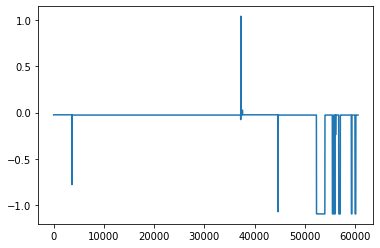

In [ ]:
plt.plot(y_hat) # scaling 전

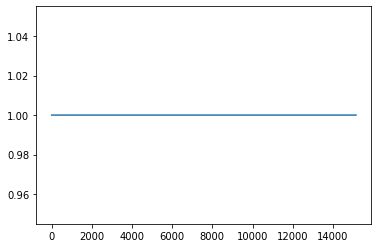

In [ ]:
plt.plot(y_pred)

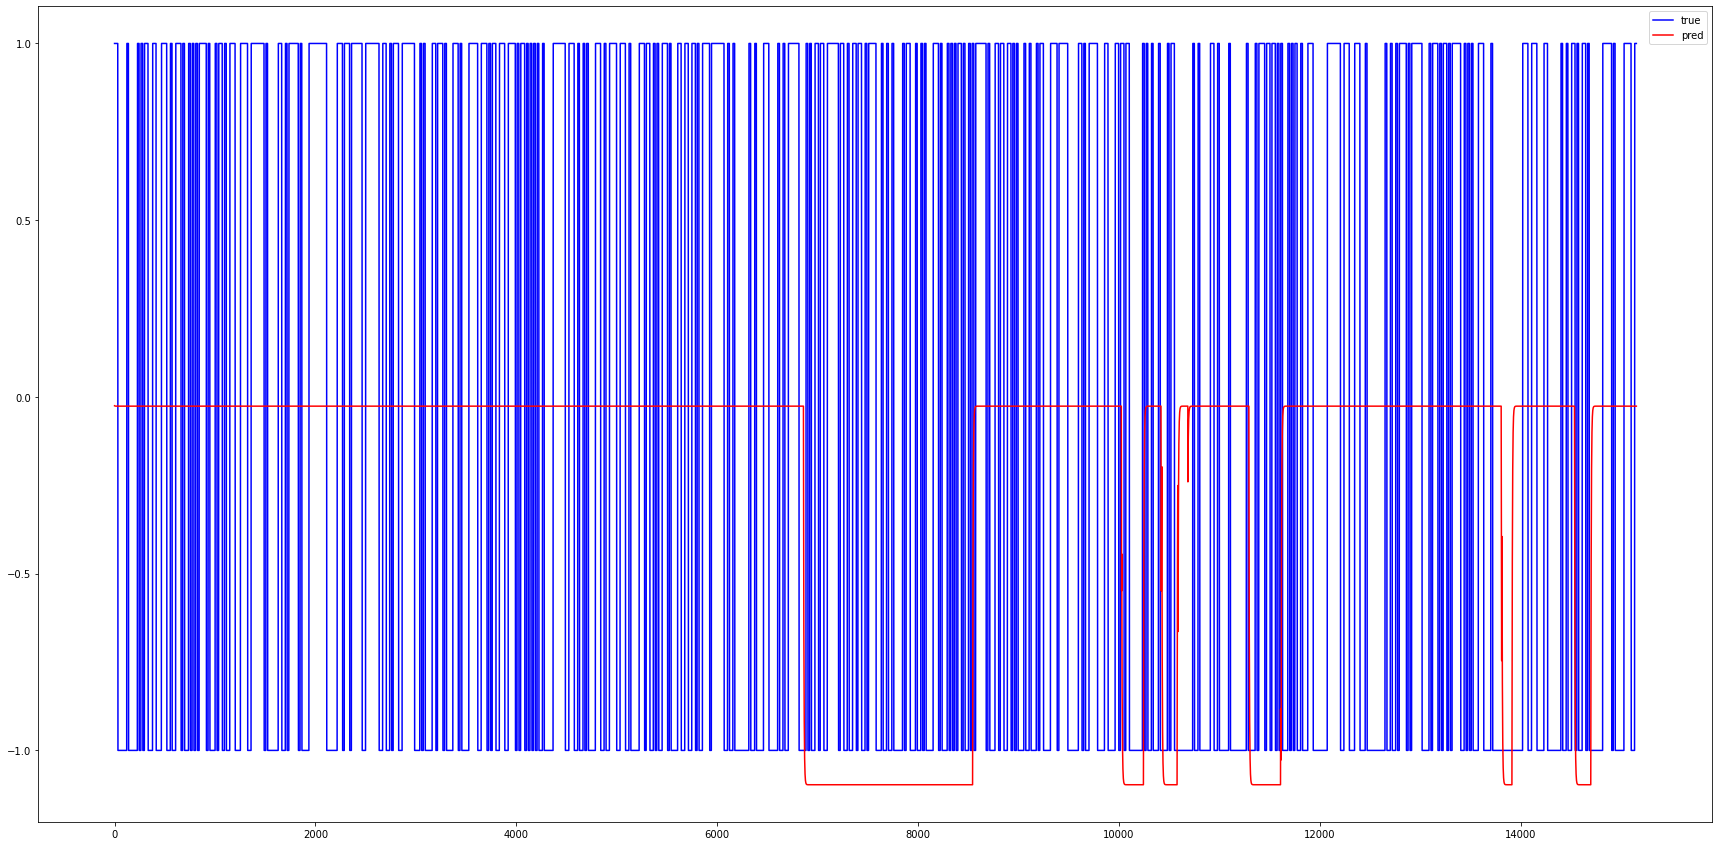

In [ ]:
# spectral radius 0.9로 고정. 고유값들은 1을 넘지 않기 떄문에 절댓값들의 최대값도 소수점으로 나올 것임.
plt.figure(figsize=(30,15))
plt.plot(y_true, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()

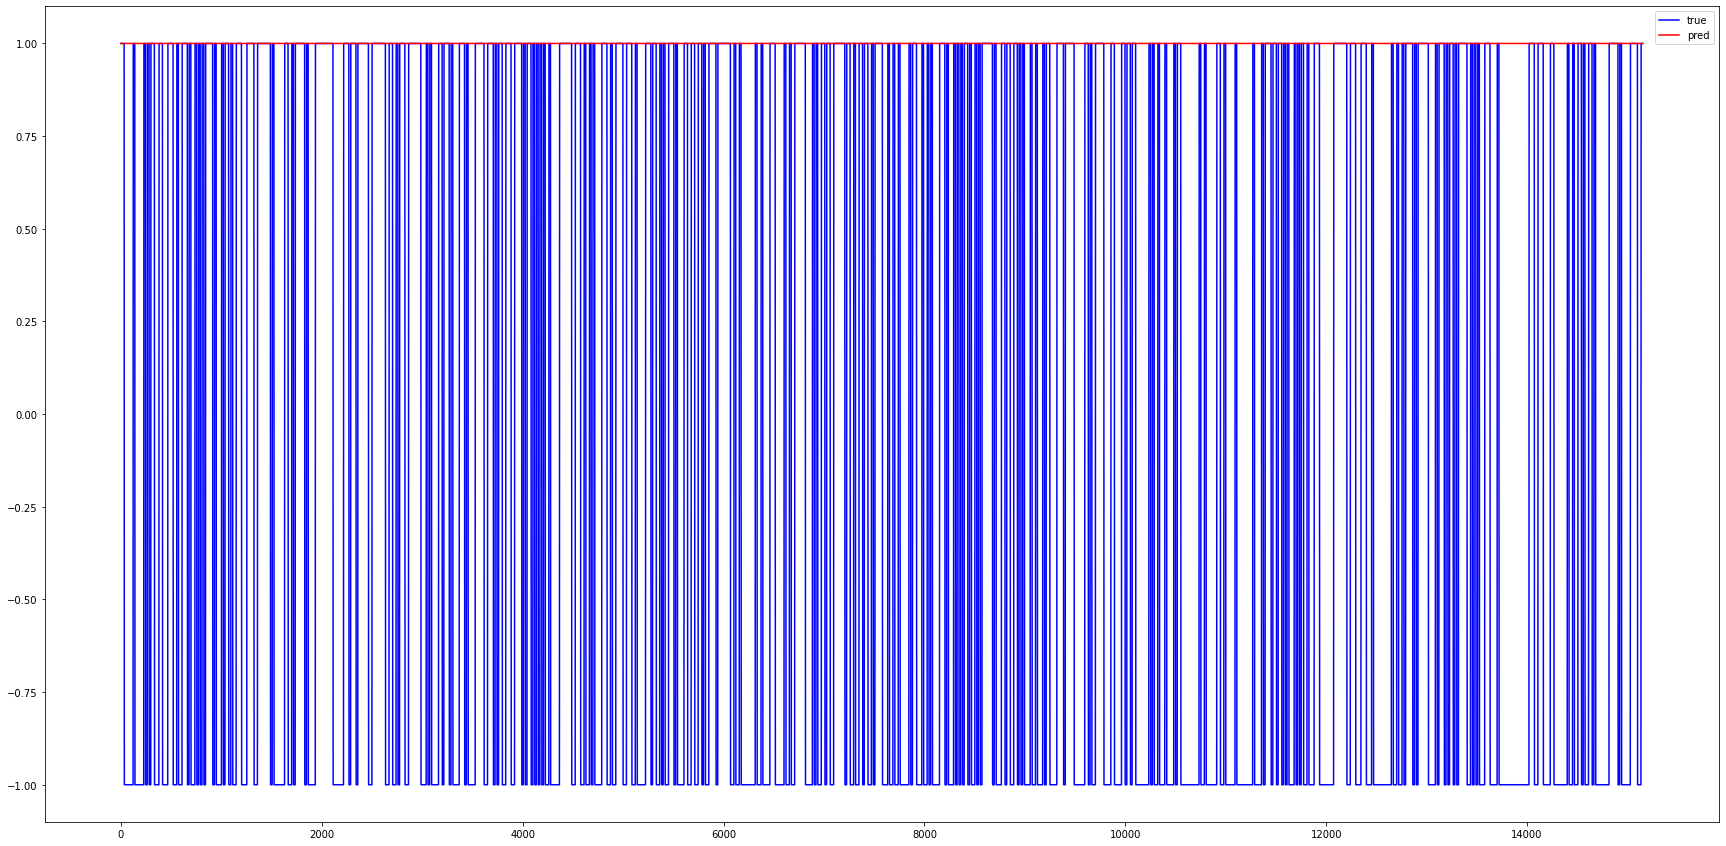

In [ ]:
# spectral radius 를 가중치들의 고유값들의 절댓값의 최댓값으로 사용(default값)
plt.figure(figsize=(30,15))
plt.plot(y_true, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()

# 5. 딥러닝 모델(MLP) - Fully Connected

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM, SimpleRNN, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

In [ ]:
X_train.shape

(45462, 36)

In [ ]:
y_train

array([-1, -1, -1, ...,  1,  1,  1])

In [ ]:
X_test

array([[ 5.16373404e+10,  4.22475828e+10,  2.49002597e+10, ...,
         1.80310344e+10,  2.94379716e+10,  4.13575807e+10],
       [ 5.16297019e+10,  4.22416034e+10,  2.48942429e+10, ...,
         1.80131840e+10,  2.94192972e+10,  4.13439783e+10],
       [ 5.16203245e+10,  4.22235845e+10,  2.48722754e+10, ...,
         1.80015281e+10,  2.94078332e+10,  4.13390346e+10],
       ...,
       [ 3.87238893e+09,  1.55415550e+09, -8.23650102e+08, ...,
        -1.91713291e+09, -1.36762279e+09,  6.34069516e+09],
       [ 3.87809482e+09,  1.55903429e+09, -8.16248467e+08, ...,
        -1.92028979e+09, -1.36600483e+09,  6.34535816e+09],
       [ 3.88275865e+09,  1.56983762e+09, -8.06065164e+08, ...,
        -1.91320395e+09, -1.35369828e+09,  6.35749660e+09]])

In [ ]:
def FC():
  input_tensor = Input(shape=(X_train.shape[1])) # 36
  x = Dense(128, activation='relu')(input_tensor) # 128
  x = Dense(256, activation='relu')(x) # 256
  x = Dense(64, activation='relu')(x) # 64
  output = Dense(3, activation='softmax')(x) # 3
  # output = Dense(2, activation='sigmoid')(x) # 2
  model = Model(inputs=input_tensor, outputs=output)
  return model

In [ ]:
model = FC()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=60, epochs=20, verbose=1)

Epoch 1/20
758/758 [==============================] - 2s 2ms/step - loss: 1.5064 - accuracy: 0.1194
Epoch 2/20
758/758 [==============================] - 1s 2ms/step - loss: 1.5064 - accuracy: 0.1194
Epoch 3/20
758/758 [==============================] - 1s 2ms/step - loss: 1.5064 - accuracy: 0.1194
Epoch 4/20
758/758 [==============================] - 1s 2ms/step - loss: 1.5064 - accuracy: 0.1194
Epoch 5/20
758/758 [==============================] - 1s 2ms/step - loss: 1.5064 - accuracy: 0.1194
Epoch 6/20
758/758 [==============================] - 1s 2ms/step - loss: 1.5064 - accuracy: 0.1194
Epoch 7/20
392/758 [==============>...............] - ETA: 0s - loss: 1.5141 - accuracy: 0.1170

In [ ]:
Y_true_FC = y_test
y_pred_FC = model.predict(X_test)

In [ ]:
y_pred_FC

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

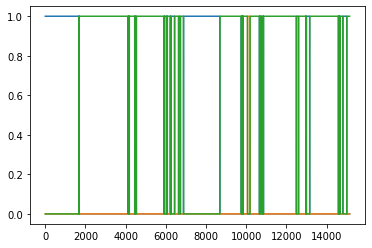

In [ ]:
plt.plot(y_pred_FC)

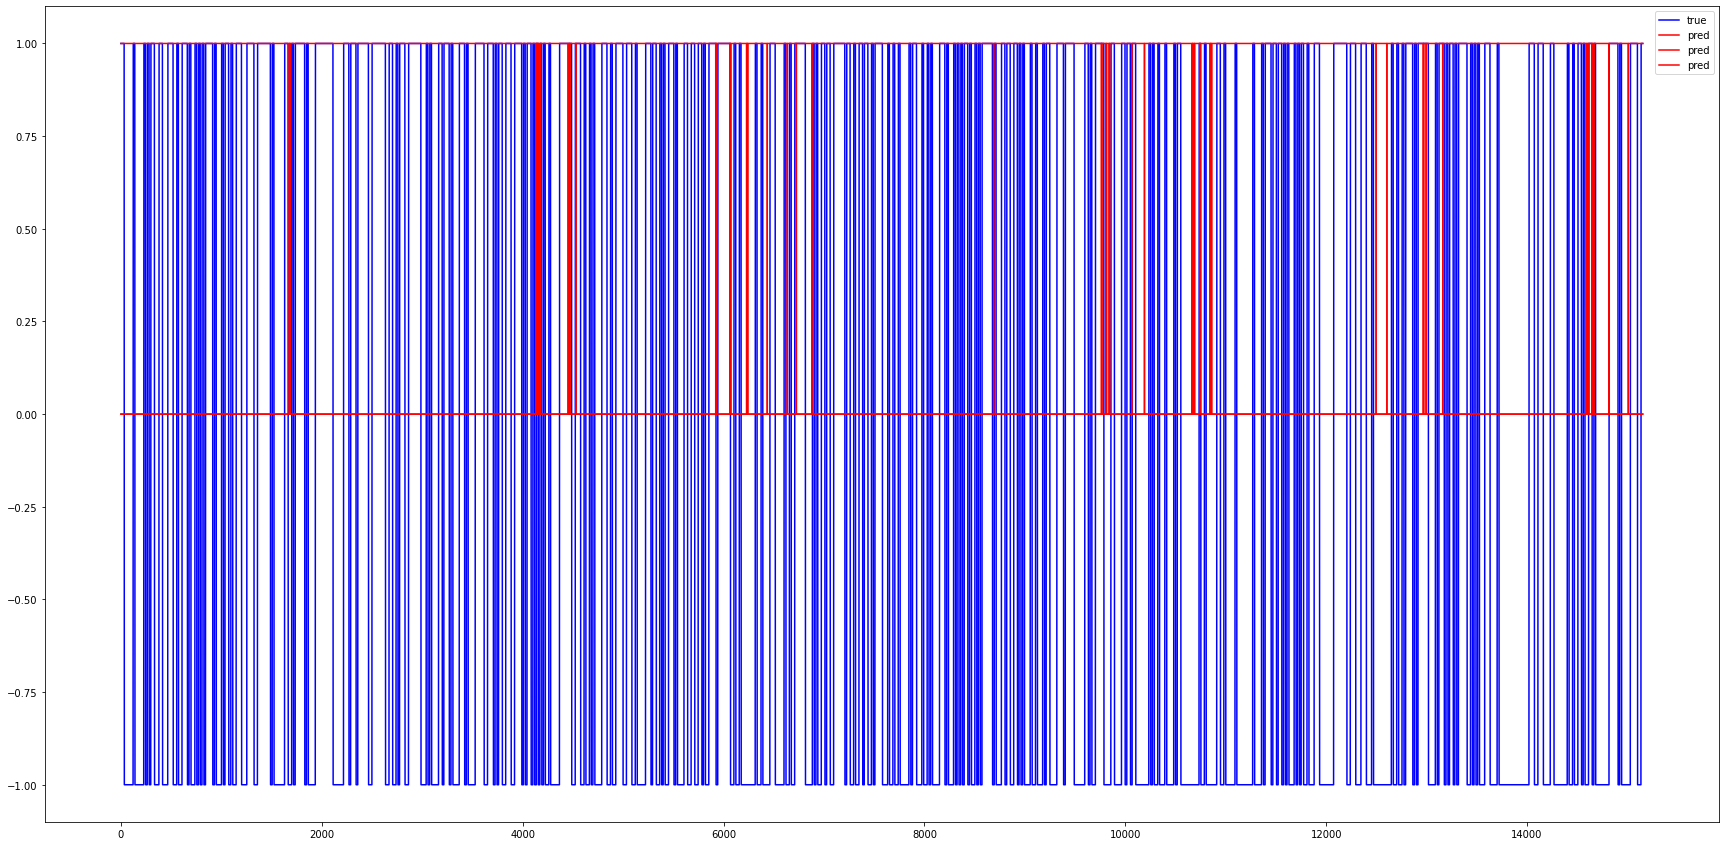

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(Y_true_FC, 'b-', label='true')
plt.plot(y_pred_FC, 'r-', label='pred')
plt.legend()

# 6. 선형 머신러닝 모델들

In [ ]:
# data split to X / Y (input / target)
train_eeg=eeg.drop(['timestamp'],axis='columns')
train_eeg=train_eeg.iloc[:,:-1].values
train_event=eeg.drop(['timestamp'],axis='columns')
train_event=train_event.iloc[:,-1].values

# data split to train / test
train_length = math.ceil(len(eeg) * 0.75) # train data : 75% of data 
#test_length = len(eeg)-train_length
""" X_train = X[:train_length]
    y_train = X[1:train_length+1]
    X_test = X[train_length:train_length+test_length]
    y_test = X[train_length+1:train_length+test_length+1]
"""

X_train = train_eeg[:train_length]
y_train= train_event[:train_length]
X_test = train_eeg[train_length:]
y_test = train_event[train_length:]

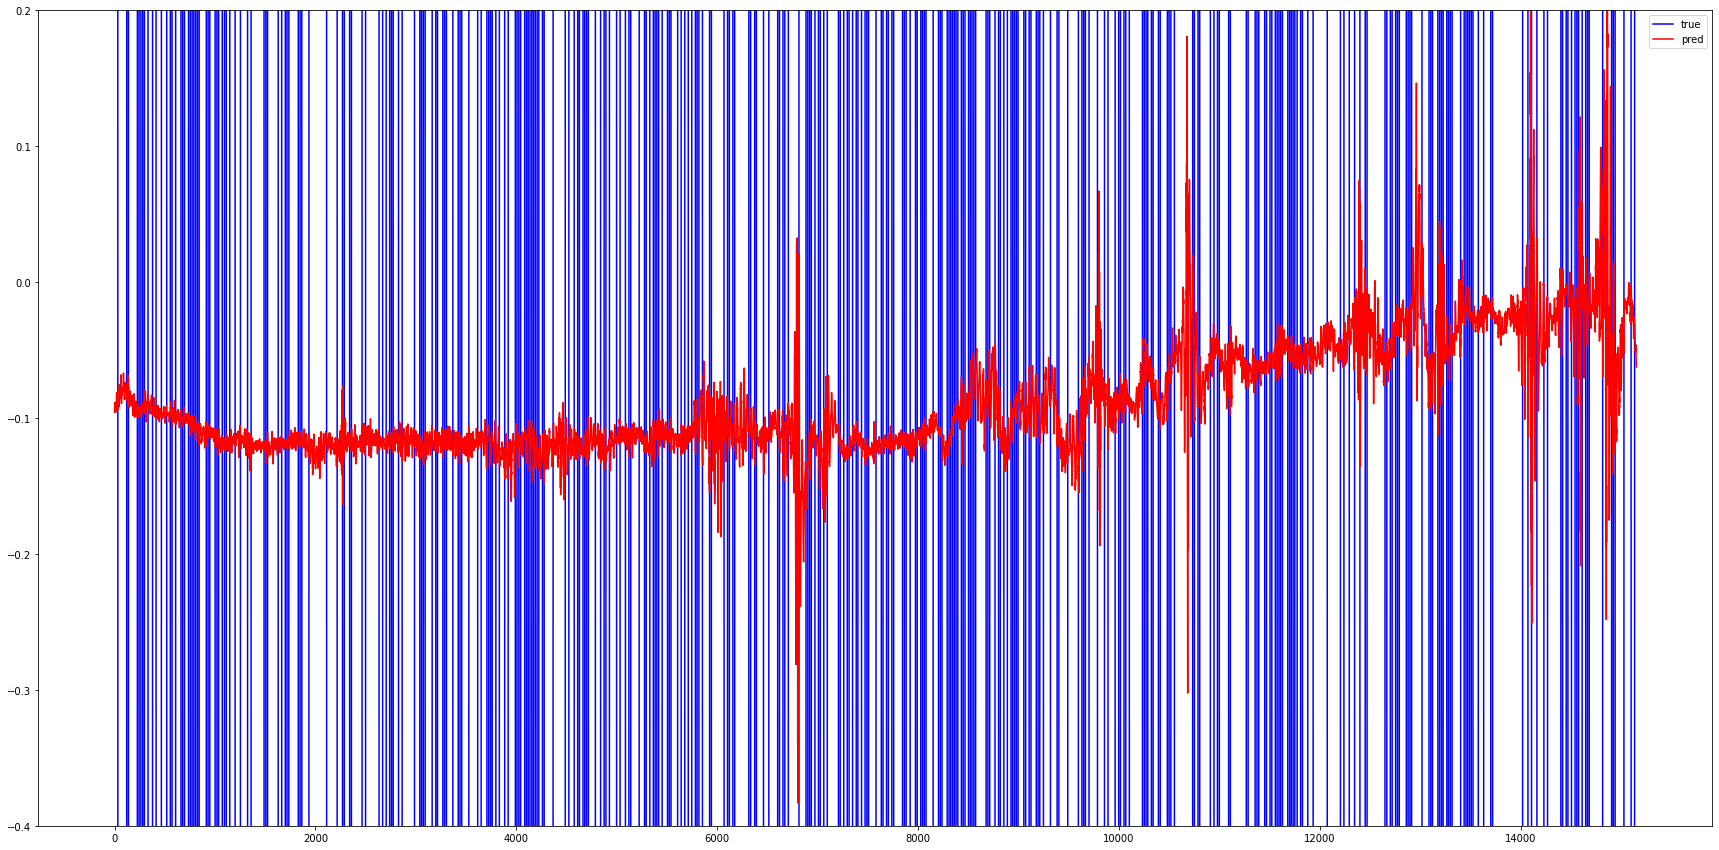

In [ ]:
# LinearRegression, Ridge, Lasso, ElasticNet, SVR
# 1. LinearRegression
model = LinearRegression()
reg = model.fit(X_train, y_train)
y_pred = reg.predict(X_test)

plt.figure(figsize=(30,15))
plt.ylim(-0.4,0.2)
plt.plot(y_test, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()

In [ ]:
joblib.dump(reg, '/content/drive/MyDrive/MNE/model/lin_model.pkl')

['/content/drive/MyDrive/MNE/model/lin_model.pkl']

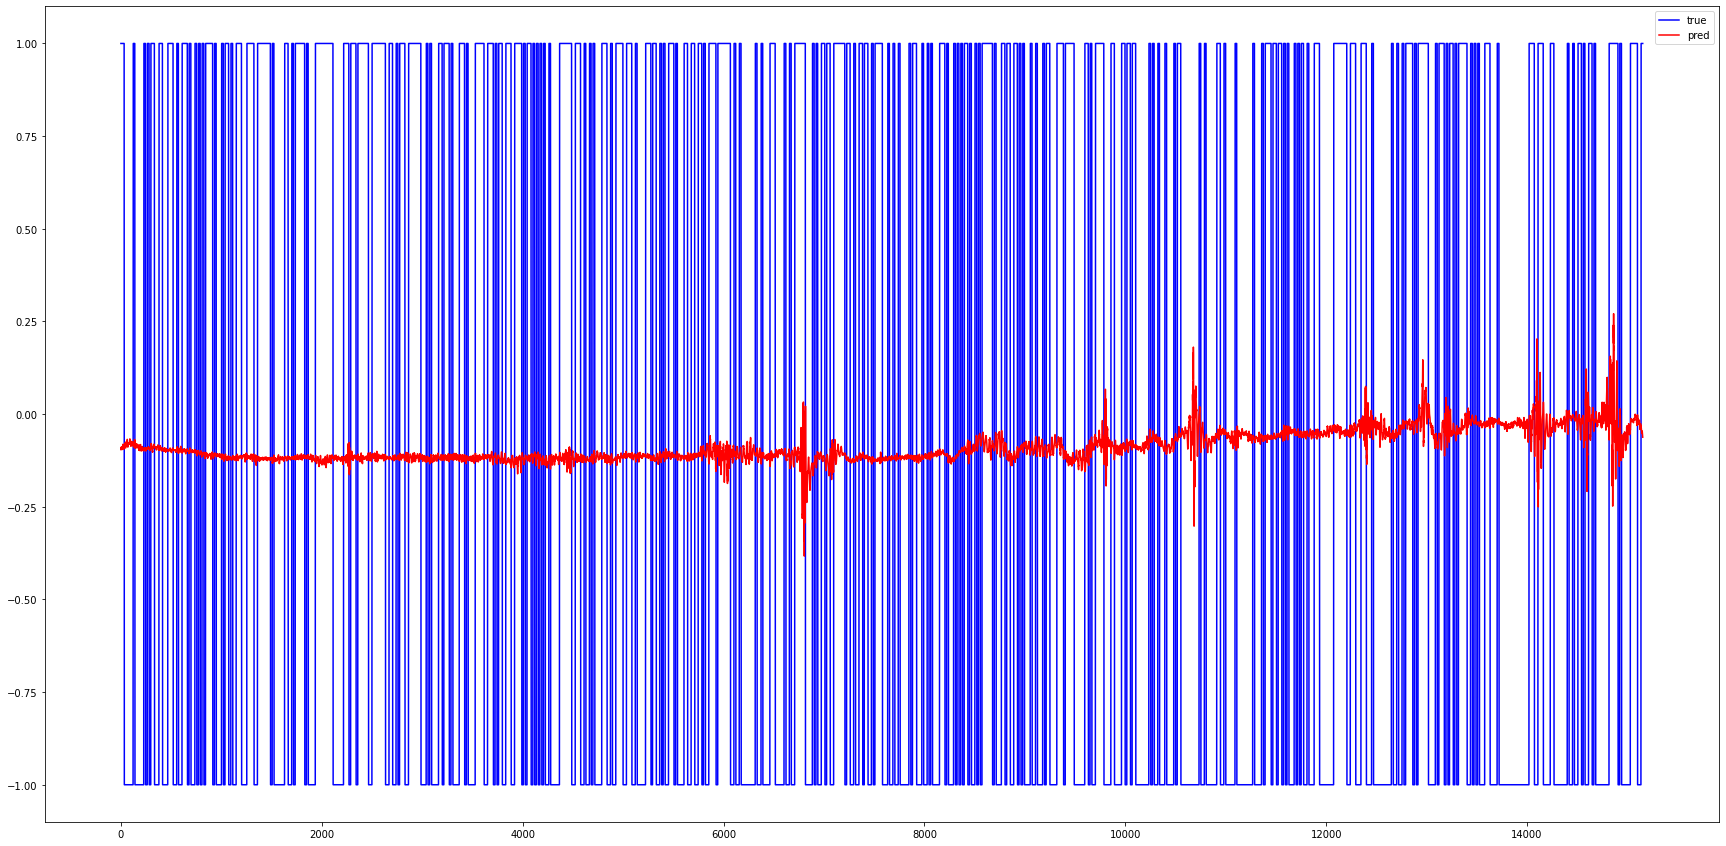

In [ ]:
# 2. Ridge(L1)
model = Ridge()
reg = model.fit(X_train, y_train)
y_pred = reg.predict(X_test)

plt.figure(figsize=(30,15))
plt.plot(y_test, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.268e+04, tolerance: 4.543e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


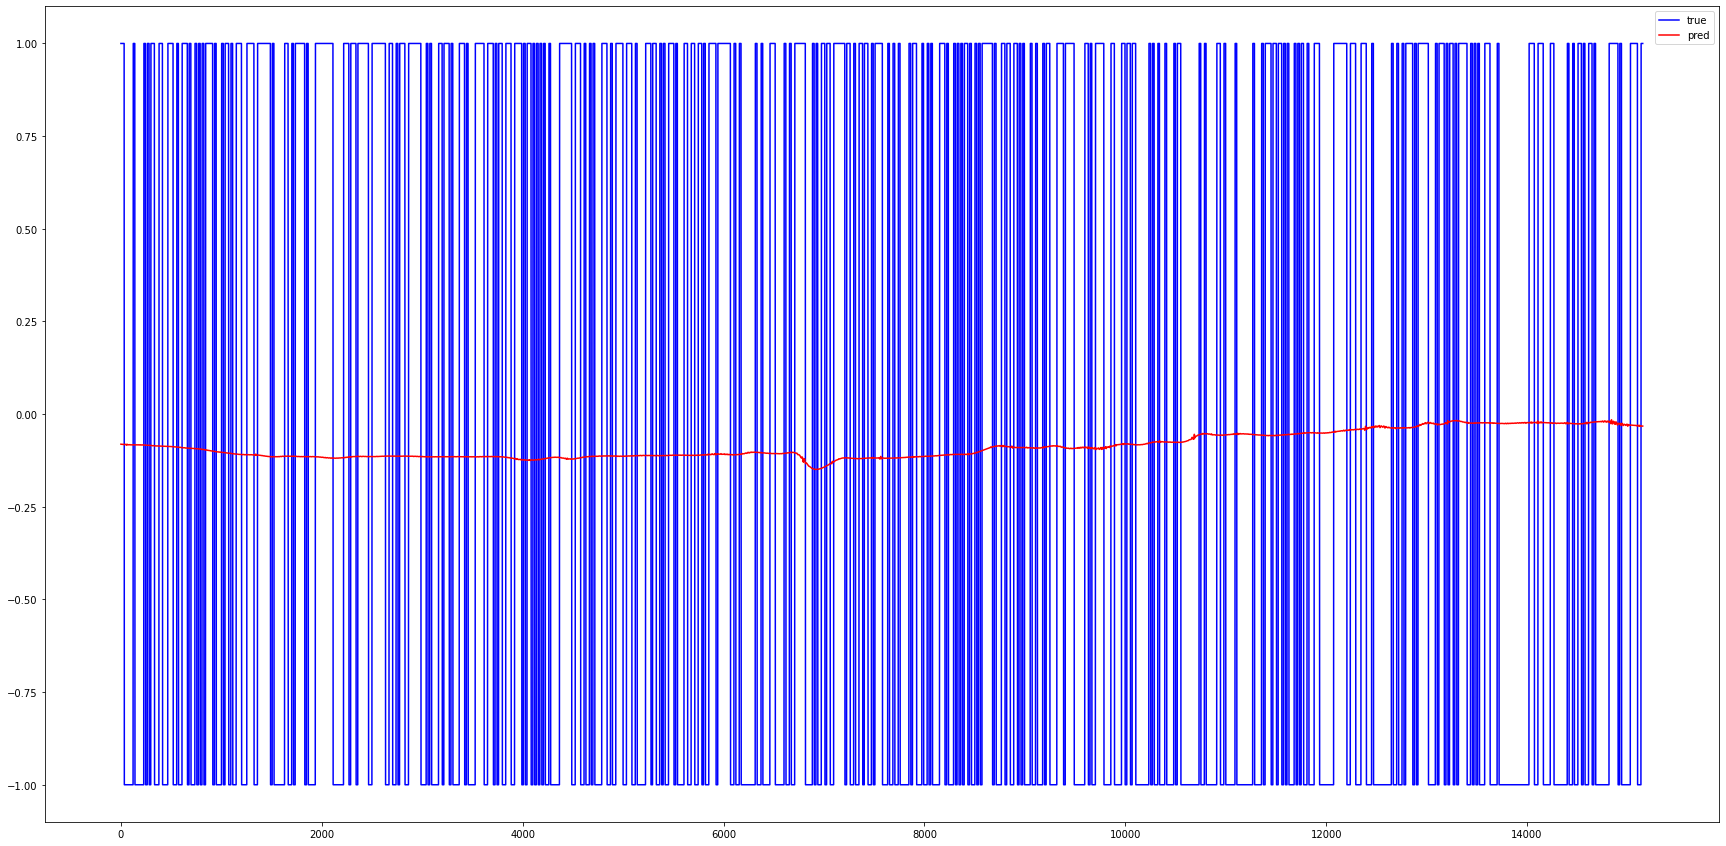

In [ ]:
# 3. Lasso(L2)
model = Lasso()
reg = model.fit(X_train, y_train)
y_pred = reg.predict(X_test)

plt.figure(figsize=(30,15))
plt.plot(y_test, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.268e+04, tolerance: 4.543e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


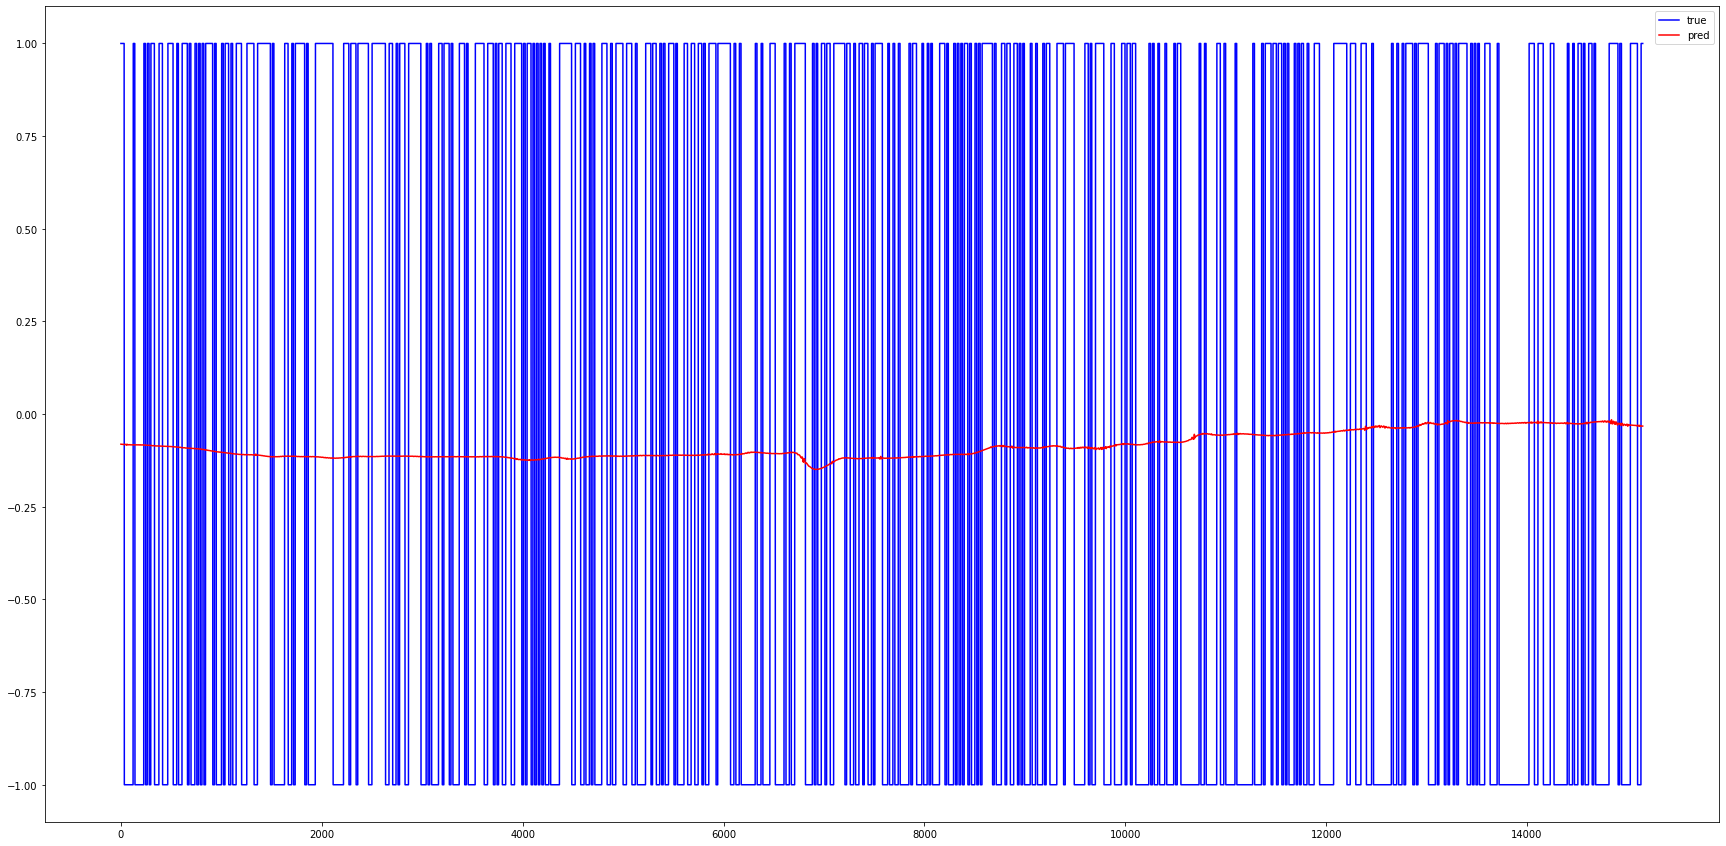

In [ ]:
# 4. ElasticNet(L1 + L2)
from sklearn.linear_model import ElasticNet
model = ElasticNet()
reg = model.fit(X_train, y_train)
y_pred = reg.predict(X_test)

plt.figure(figsize=(30,15))
plt.plot(y_test, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()

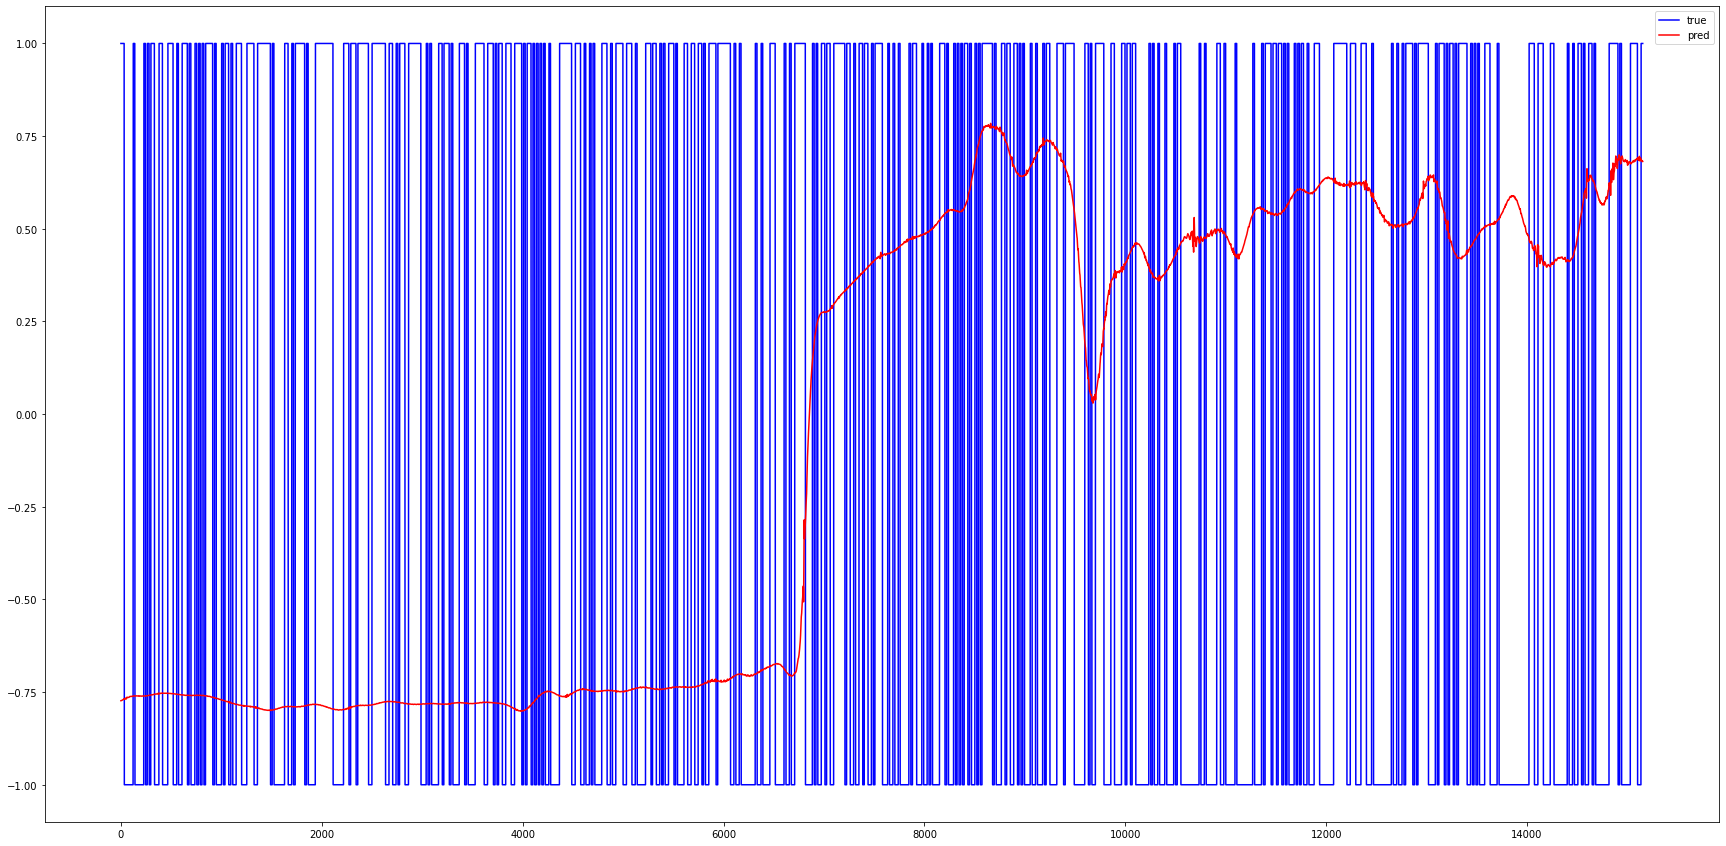

In [ ]:
# 5. SVR(Soft Vector Regression)
model = SVR()
reg = model.fit(X_train, y_train)
y_pred = reg.predict(X_test)

plt.figure(figsize=(30,15))
plt.plot(y_test, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()

# 7. 정리

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import math

# data filtering using by user-defined function
eeg=filtering_bandpass(eeg)

eeg['timestamp']=pd.to_datetime(eeg['timestamp'])
train['timestamp']=pd.to_datetime(train['timestamp'])
train=train.rename(columns={' event(1:up':'event'})

eeg_band = eeg.iloc[:,17:]
eeg = eeg.iloc[:,:17]

eeg['event']=0

# deploy target data to eeg data by timestamp (merge train data and eeg data)
for i in range(0,len(train)-1):
  for t in range(0,len(eeg)):
    if train['timestamp'][i]< eeg['timestamp'][t] and (train['timestamp'][i+1]>eeg['timestamp'][t])==True:
       eeg.event[t]=train.event[i]

# drop the columns which doesn't have target data
eeg.drop(eeg.loc[eeg['event']==0].index, inplace=True)

# data split to X / Y (input / target)
train_eeg=eeg.drop(['timestamp'],axis='columns')
train_eeg=train_eeg.iloc[:,:-1].values
train_event=eeg.drop(['timestamp'],axis='columns')
train_event=train_event.iloc[:,-1].values

# data split to train / test
train_length = math.ceil(len(eeg) * 0.75) # train data : 75% of data 
#test_length = len(eeg)-train_length
""" X_train = X[:train_length]
    y_train = X[1:train_length+1]
    X_test = X[train_length:train_length+test_length]
    y_test = X[train_length+1:train_length+test_length+1]
"""

X_train = train_eeg[:train_length]
y_train= train_event[:train_length]
X_test = train_eeg[train_length:]
y_test = train_event[train_length:]

# Simple training
# ESN 모델 생성
# n_readout : 출력층 뉴런수, n_components : reservoir 뉴런수, damping : reservoir 내 뉴런 손실률(뉴런끼리 연결 안될 확률), weight_scaling : 가중치 학습률
my_esn = SimpleESN(n_readout=2, n_components=len(eeg.columns),
                       damping=0.2, weight_scaling=1.25)
'''학습 과정'''
# ESN 모델 사용(통과)
echo_train = my_esn.fit_transform(X_train)
# ESN 거친 후 머신러닝 모델 사용(선형회귀)
# regr = Ridge(alpha=0.05)
regr = LinearRegression()
# regr = SVR()
# 머신러닝 모델 학습
regr.fit(echo_train, y_train)

'''모델 사용 과정'''
# 머신러닝 모델 사용
echo_test = my_esn.transform(X_test)
# 예측
y_true, y_pred = y_test, regr.predict(echo_test)
# 오차
err = mean_squared_error(y_true, y_pred)

In [ ]:
# 시각화
plt.figure(figsize=(15,8))
plt.plot(y_true, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()